In [49]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [50]:
sns.set(color_codes=True)

In [51]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [108]:
pd.isnull(test).sum()

Id                 0
DetectedCamera     0
AngleOfSign        0
SignAspectRatio    0
SignWidth          0
SignHeight         0
DC                 0
dtype: int64

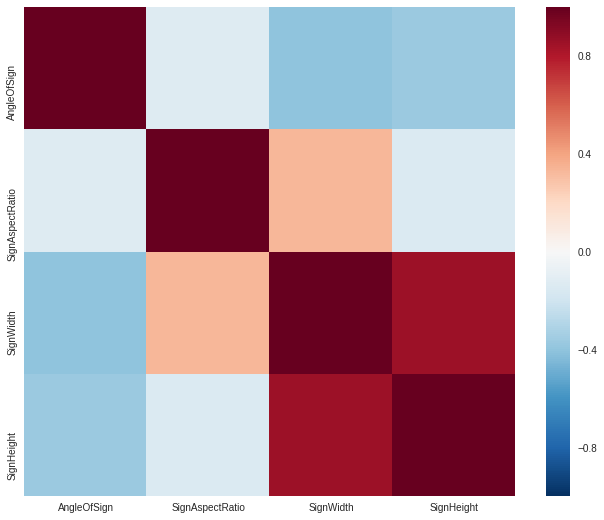

In [53]:
corr=train.corr()
plt.subplots(figsize=(11,9))
sns.heatmap(corr,vmax=1,vmin=-1)


In [54]:
le = LabelEncoder()
le.fit(train.DetectedCamera)

LabelEncoder()

In [55]:
le.classes_

array(['Front', 'Left', 'Rear', 'Right'], dtype=object)

In [56]:
train['DC'] = le.transform(train.DetectedCamera).astype('int64')
train['label'] = le.transform(train['SignFacing (Target)']).astype('int64')

In [42]:
train_array = train.values

In [58]:
test['DC'] = le.transform(test.DetectedCamera).astype('int64')

In [61]:
train_label = train['label']

training = train.drop(labels=['Id', 'DetectedCamera', 'SignFacing (Target)', 'label'], axis=1)
testing = test.drop(labels=['Id', 'DetectedCamera'], axis=1)

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

In [65]:
training.dtypes

AngleOfSign          int64
SignAspectRatio    float64
SignWidth            int64
SignHeight           int64
DC                   int64
dtype: object

In [ ]:
kfold = KFold(n_splits=5, random_state=7)
model = XGBClassifier(objective="multi:softprob", n_estimators=500, learning_rate=0.1)
metric = 'log_loss'
score = cross_val_score(model,training, train_label, cv=kfold, scoring=metric )
score.mean()+100

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [125]:
model = XGBClassifier(objective='multi:softprob', n_estimators=2500, learning_rate=0.01)
model.fit(training, train_label)
prediction = model.predict_proba(testing)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2500, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [127]:
subm_file = pd.read_csv('sample_submission.csv')



In [128]:
subm_file['Id'] = test['Id']
subm_file['Front'] = prediction[:,0]
subm_file['Left'] = prediction[:,1]
subm_file['Rear'] = prediction[:,2]
subm_file['Right'] = prediction[:,3]

In [129]:
subm_file.to_csv('subm.csv', index=None)